In [18]:
import numpy as np
import glob, os
import xarray as xr
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import shapely.geometry as sgeom
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [2]:
# xr.set_options(display_style='text')

In [3]:
# topfile = '/global/project/projectdirs/m1867/zfeng/globe_topography/ETOPO1_Ice_g_gmt4.nc'
topfile = '/global/cfs/cdirs/m1867/zfeng/globe_topography/ETOPO_2022_v1_30s_N90W180_surface.nc'
# topfile_csapr = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
topfile_csapr = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/CACTI_Domain_30m.Surface_Elevation.nc'

figdir = '/pscratch/sd/f/feng045/SAAG/hist/maps/'
# figdir_csapr = '/pscratch/sd/f/feng045/SAAG/hist/maps/'

In [4]:
# Read terrain file
dstop = xr.open_dataset(topfile)
dstop

<xarray.Dataset>
Dimensions:  (lat: 21600, lon: 43200)
Coordinates:
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    crs      |S1 ...
    z        (lat, lon) float32 ...
Attributes:
    GDAL_AREA_OR_POINT:             Area
    node_offset:                    1
    GDAL_TIFFTAG_COPYRIGHT:         DOC/NOAA/NESDIS/NCEI > National Centers f...
    GDAL_TIFFTAG_DATETIME:          20220929123913.0
    GDAL_TIFFTAG_IMAGEDESCRIPTION:  Topography-Bathymetry; EGM2008 height
    Conventions:                    CF-1.5
    GDAL:                           GDAL 3.3.2, released 2021/09/01
    NCO:                            netCDF Operators version 4.9.1 (Homepage ...

In [64]:
# Radar lat/lon
amf_site = 'COR'
# amf_site = 'MAO'
if amf_site == 'COR':
    radar_lon, radar_lat = -64.75, -32.1
    # Subet domain
    wlon_ll = radar_lon-1.5  # lower left corner
    wlat_ll = radar_lat-2.  # lower left corner
    wlon_ur = radar_lon+2.5  # upper right corner
    wlat_ur = radar_lat+2.  # upper right corner
elif amf_site == 'MAO':
    radar_lon, radar_lat = -59.9914, -3.1489
    # Subet domain
    wlon_ll = radar_lon-2.0  # lower left corner
    wlat_ll = radar_lat-2.0  # lower left corner
    wlon_ur = radar_lon+2.0  # upper right corner
    wlat_ur = radar_lat+2.0  # upper right corner
    
# map_extent = [radar_lon-2, radar_lon+2, radar_lat-2, radar_lat+2]
buffer = 0.5
map_extent = [wlon_ll-buffer, wlon_ur+buffer, wlat_ll-buffer, wlat_ur+buffer]

print(f'Subset corners: {wlon_ll:.02f}, {wlon_ur:.02f}, {wlat_ll:.02f}, {wlat_ur:.02f}')

Subset corners: -66.25, -62.25, -34.10, -30.10


In [65]:
buffer_ter = 25
lonmin, lonmax = radar_lon-buffer_ter, radar_lon+buffer_ter
latmin, latmax = radar_lat-buffer_ter, radar_lat+buffer_ter
print(f'Terrain data subset: {lonmin}, {lonmax}, {latmin}, {latmax}')

Terrain data subset: -89.75, -39.75, -57.1, -7.100000000000001


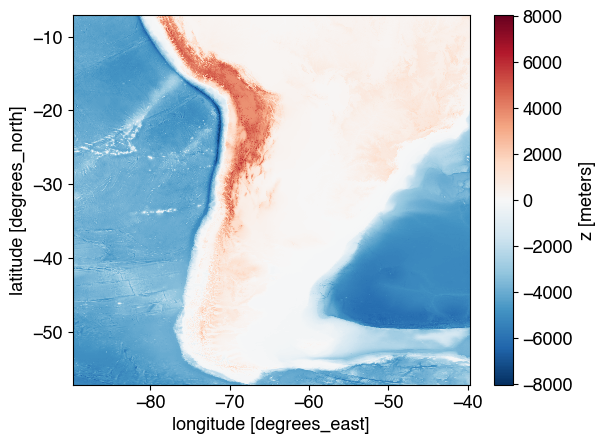

In [66]:
# Crop region
# lonmin, lonmax = -90., -20.
# latmin, latmax = -60., -10.
ter = dstop.z.sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax))
lon = dstop.lon.sel(lon=slice(lonmin,lonmax))
lat = dstop.lat.sel(lat=slice(latmin,latmax))
landmask = ter >= 0
ter.plot()

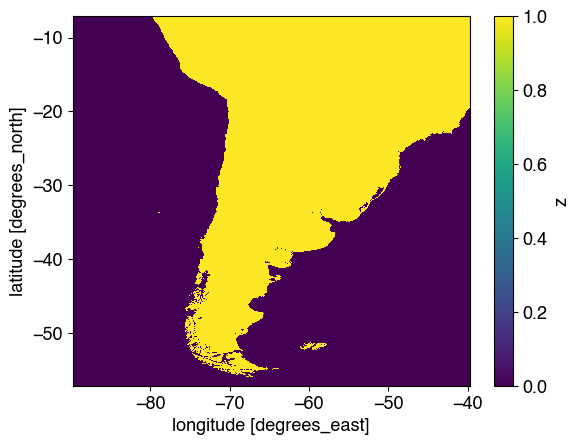

In [67]:
landmask.plot()

In [68]:
# dsc = xr.open_dataset(topfile_csapr)
# dsc

In [69]:
# # Coarsen the terrain data by 10x
# # dscc = dsc.coarsen(x=10, y=10, boundary='trim', keep_attrs=True).mean()
# dscc = dsc.coarsen(longitude=5, latitude=5, boundary='trim', keep_attrs=True).mean()
# dscc

In [70]:
# # dscc.height.plot(cmap='terrain')
# plt.pcolormesh(dscc.longitude, dscc.latitude, dscc.height, shading='auto', vmin=0, vmax=2500, cmap='terrain')
# plt.colorbar()

In [71]:
# lon_wrfbox = [-72.9671, -52.43289, -52.43289, -72.9671, -72.9671]
# lat_wrfbox = [-38.34014, -38.34014, -24.947563, -24.947563, -38.34014]

In [72]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [73]:
def compute_radius(proj, lat, lon, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = proj.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

In [74]:
if amf_site == 'COR':
    levels = np.arange(0,4000.1,50)
    cbticks = np.arange(0,4000.1,500)
if amf_site == 'MAO':
    levels = np.arange(0,2000.1,20)
    cbticks = np.arange(0,2000.1,200)

/pscratch/sd/f/feng045/SAAG/hist/maps/subset_map_COR.png


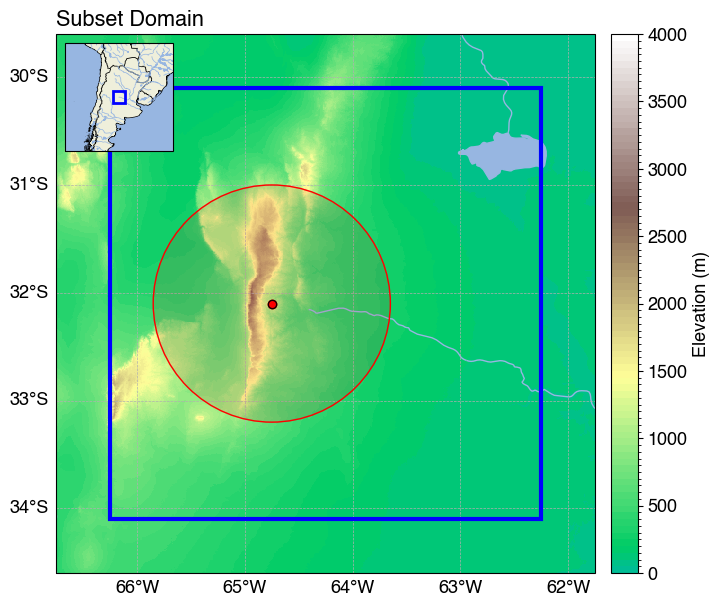

In [75]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

# map_extent = [25, 35, -6, 4]
buffer_ins = 15
map_extent_ins = [map_extent[0]-buffer_ins, map_extent[1]+buffer_ins, map_extent[2]-buffer_ins, map_extent[3]+buffer_ins]
lonv = np.arange(-180,180.1,1)
latv = np.arange(-80,80.1,1)
lonvals = mpl.ticker.FixedLocator(lonv)
latvals = mpl.ticker.FixedLocator(latv)

fig = plt.figure(figsize=[10,7], dpi=100)
resolution = '10m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', resolution)
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution)
proj = ccrs.PlateCarree()
data_proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extent, crs=proj)
ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
ax.add_feature(lakes, facecolor=cfeature.COLORS['water'], edgecolor=cfeature.COLORS['water'], zorder=2)
ax.add_feature(rivers, facecolor='none', linewidth=1, edgecolor=cfeature.COLORS['water'], zorder=2)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
# gl.xlabels_top = False
# gl.ylabels_right = False
gl.top_labels = False
gl.right_labels = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
# levels = np.arange(0,4000.1,50)
# cbticks = np.arange(0,4000.1,500)
cmap = plt.get_cmap('terrain')
cmap = truncate_colormap(cmap, 0.22, 1)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cf1 = plt.pcolormesh(lon, lat, ter, norm=norm, shading='auto', cmap=cmap, transform=proj, zorder=1)
cb = plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('Subset Domain', loc='left')

# # Annotate countries
# color_country = 'k'
# for country, (slat, slon) in selected_country_centers.items():
#     ax.text(slon, slat, country, transform=data_proj, ha='center', va='center', color=color_country, fontweight='bold', zorder=10)
# # Annotate Lake Victoria
# lat_lake, lon_lake = -1., 33.
# ax.text(lon_lake, lat_lake, 'Lake\nVictoria', transform=data_proj, ha='center', va='center', color='mediumblue', fontweight='bold', zorder=10)

# AMF site
# radar_lon, radar_lat = 30.54, -1.49
ax.plot(radar_lon, radar_lat, color='red', marker='o', markersize=6)
ax.plot(radar_lon, radar_lat, color='k', marker='o', markersize=6, fillstyle='none')
# ax.text(radar_lon, radar_lat-1, 'AMF', color='k', fontsize=15, zorder=10)

# Draw a patch circle
r_proj = 1.1  # radius [degree]
ax.add_patch(mpatches.Circle(xy=[radar_lon, radar_lat], radius=r_proj, color='red', alpha=0.1, transform=proj, zorder=6))
ax.add_patch(mpatches.Circle(xy=[radar_lon, radar_lat], radius=r_proj, facecolor='none', edgecolor='red', transform=proj, zorder=6))

# Subset domain
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(wlon_ll, wlat_ll, data_proj)
x2, y2 = proj.transform_point(wlon_ur, wlat_ur, data_proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='b', zorder=10))

# Create an inset GeoAxes showing the location of the domain
axins = inset_axes(ax, width="20%", height="20%", loc="upper left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=0.5, axes_kwargs=dict(projection=proj))
axins.set_extent(map_extent_ins, proj)
# # Make a nice border around the inset axes.
# effect = path_effects.Stroke(linewidth=4, foreground='wheat', alpha=0.5)
# axins.outline_patch.set_path_effects([effect])
    
# Add land, coastlines, borders to inset
axins.add_feature(land, facecolor=cfeature.COLORS['land'], edgecolor='k', zorder=0)
axins.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'], zorder=0)
axins.add_feature(borders, edgecolor='k', facecolor='none', lw=0.6, zorder=2)
axins.add_feature(rivers, facecolor='none', linewidth=0.5, edgecolor=cfeature.COLORS['water'], zorder=2)
axins.add_feature(lakes, facecolor=cfeature.COLORS['water'], edgecolor=cfeature.COLORS['water'], zorder=1)
# Plot a box to show the domain
# map_domain = sgeom.box(minx=map_extent[0], maxx=map_extent[1], miny=map_extent[2], maxy=map_extent[3])
# axins.add_geometries([map_domain], proj, facecolor='none', edgecolor='b', lw=2, zorder=5)
# Plot rectangle
axins.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='b', zorder=10))

figname = f'{figdir}subset_map_{amf_site}.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
print(figname)

In [13]:
def calc_latlon(lon1, lat1, dist, angle):
    """
    Haversine formula to calculate lat/lon locations from distance and angle.
    
    lon1:   longitude in [degree]
    lat1:   latitude in [degree]
    dist:   distance in [km]
    angle:  angle in [degree]
    """

    import math

    # Earth radius
    # R_earth = 6378.39  # at Equator [km]
    R_earth = 6374.2  # at 40 degree latitude [km]
#     R_earth = 6356.91  # at the pole [km]

    # Conver degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(angle)

    lat2 = math.asin(math.sin(lat1) * math.cos(dist/R_earth) +
                     math.cos(lat1) * math.sin(dist/R_earth) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(dist/R_earth) * math.cos(lat1),
                             math.cos(dist/R_earth) - math.sin(lat1) * math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lon2, lat2

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaad9cdb4f0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaad9cdb680> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaad9dfdf90> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coord

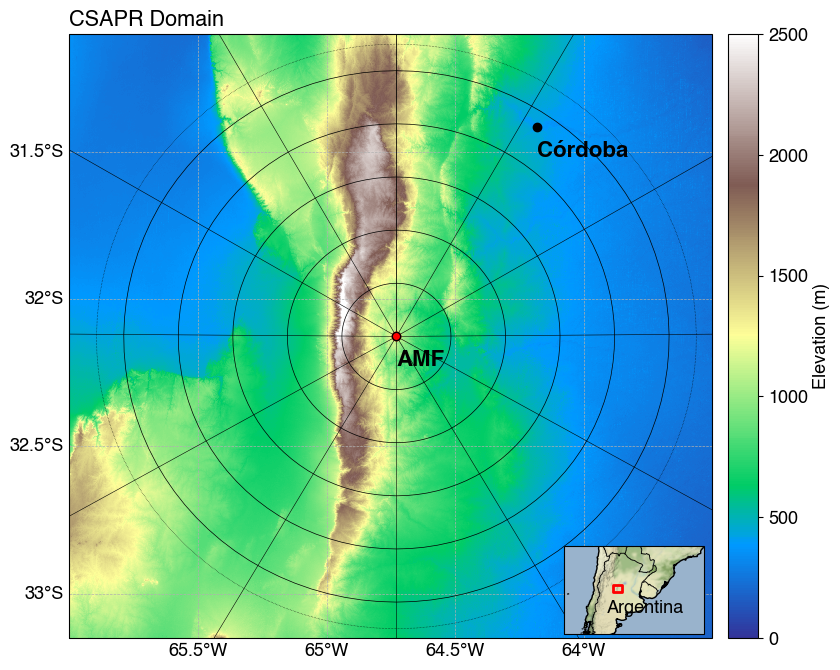

In [17]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

lonmin = -66
lonmax = -63.5
latmin = -33.15
latmax = -31.1
map_extend = [lonmin, lonmax, latmin, latmax]
lonvals = mpl.ticker.FixedLocator(np.arange(-70,-60.1,0.5))
latvals = mpl.ticker.FixedLocator(np.arange(-40,-30.1,0.5))

fig = plt.figure(figsize=[10,8], dpi=100)
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extend, crs=proj)
# ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
# ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
# ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
ax.set_aspect('auto', adjustable=None)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
levels = np.arange(0,2500.1,10)
cbticks = np.arange(0,2500.1,500)
cmap = plt.get_cmap('terrain')
# cmap = truncate_colormap(cmap, 0.22, 1)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
cf = plt.pcolormesh(dscc.longitude, dscc.latitude, dscc.height, shading='nearest', 
                    norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
# cf = plt.pcolormesh(dsc.x, dsc.y, dsc.z, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
# cf = ax.contourf(dsc.x, dsc.y, dsc.z, levels=levels, cmap=cmap, transform=proj)
cb = plt.colorbar(cf, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('CSAPR Domain', loc='left')

radii = np.arange(20,101,20)  # radii for the range rings [km]
azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location
cor_lon, cor_lat = -64.183333, -31.416667  # Cordoba city location

ax.plot(radar_lon, radar_lat, color='red', marker='o', markersize=6, zorder=10)
ax.plot(radar_lon, radar_lat, color='k', marker='o', markersize=6, fillstyle='none', zorder=10)
ax.text(radar_lon, radar_lat-0.1, 'AMF', color='k', fontsize=16, fontweight='bold', zorder=10)
ax.plot(cor_lon, cor_lat, color='k', marker='o', markersize=6, zorder=10)
ax.text(cor_lon, cor_lat-0.1, 'Córdoba', color='k', fontsize=16, fontweight='bold', zorder=10)

# Plot range circles around radar
for ii in range(0, len(radii)):
    rr = ax.tissot(rad_km=radii[ii], lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='None', edgecolor='k', lw=0.5, zorder=3)
rr = ax.tissot(rad_km=110, lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='None', edgecolor='k', ls=':', lw=0.4, zorder=3)
# Plot azimuth lines
for ii in range(0, len(azimuths)):
    lon2, lat2 = calc_latlon(radar_lon, radar_lat, 150, azimuths[ii])
    ax.plot([radar_lon,lon2], [radar_lat,lat2], color='k', lw=0.4, transform=proj, zorder=5)
    
# Create an inset GeoAxes showing the location of the domain
sub_ax = plt.axes([0.62, 0.06, 0.14, 0.25], projection=proj)
sub_ax.set_extent([-80, -40, -45, -20], proj)
# # Make a nice border around the inset axes.
# effect = path_effects.Stroke(linewidth=4, foreground='wheat', alpha=0.5)
# sub_ax.outline_patch.set_path_effects([effect])
    
# Add land, coastlines, borders to inset
# sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k', zorder=4)
sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
# sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'], zorder=4)
sub_ax.add_feature(borders, edgecolor='k', facecolor='none', lw=0.6, zorder=4)
# Add the Stamen data at zoom level X (larger number is higher resolution).
stamen_terrain = cimgt.Stamen('terrain-background')
sub_ax.add_image(stamen_terrain, 4)
# Add CSAPR domain box
csapr_domain = sgeom.box(minx=map_extend[0], maxx=map_extend[1], miny=map_extend[2], maxy=map_extend[3])
sub_ax.add_geometries([csapr_domain], proj, facecolor='none', edgecolor='r', lw=2, zorder=5)
sub_ax.text(-68, -39, 'Argentina', color='k', fontsize=13, ha='left', zorder=5)

figname = f'{figdir_csapr}CACTI_CSAPR_terrain_map.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')